# Forensic Fraud Detection — Full Step-by-Step Notebook



## 1) Load & Explore Data

Read the CSV and inspect basic info.

In [5]:

import pandas as pd, numpy as np
df_raw = pd.read_csv("C:\\Users\\USER\\Downloads\\fraud_data.csv", dtype=str)
print("Shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.dtypes)


Shape: (14446, 15)


,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


trans_date_trans_time    object
merchant                 object
category                 object
amt                      object
city                     object
state                    object
lat                      object
long                     object
city_pop                 object
job                      object
dob                      object
trans_num                object
merch_lat                object
merch_long               object
is_fraud                 object
dtype: object

## 2) Show first rows (parsed numeric columns)

In [7]:

df = df_raw.copy()
for c in ['amt','lat','long','city_pop','merch_lat','merch_long']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
display(df.head())


,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


## 3) Summary (normal vs fraud counts)
Clean the is_fraud column and show counts.

In [9]:

import re
def extract_leading_digit(x):
    s = str(x)
    m = re.search(r'([01])', s)
    return int(m.group(1)) if m else np.nan
target = 'is_fraud' if 'is_fraud' in df.columns else df.columns[-1]
df['is_fraud_clean'] = df[target].apply(extract_leading_digit)
print("Counts:")
print(df['is_fraud_clean'].value_counts(dropna=False))
print("Percent:")
print(df['is_fraud_clean'].value_counts(normalize=True, dropna=False)*100)


Counts:
is_fraud_clean
0    12601
1     1845
Name: count, dtype: int64
Percent:
is_fraud_clean
0    87.228298
1    12.771702
Name: proportion, dtype: float64


## 4) Visualization of fraud vs normal (bar chart)

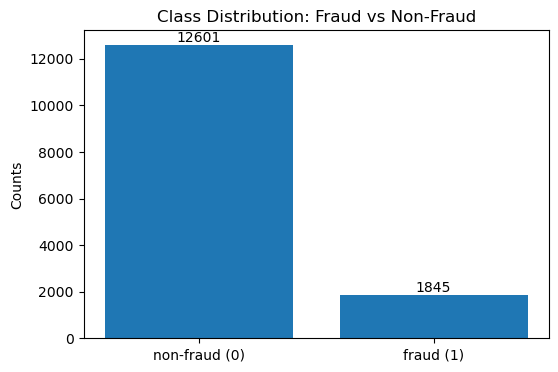

In [5]:

import matplotlib.pyplot as plt
counts = df['is_fraud_clean'].value_counts().sort_index()
labels = ['non-fraud (0)','fraud (1)']
values = [counts.get(0,0), counts.get(1,0)]
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.ylabel("Counts")
for i,v in enumerate(values):
    plt.text(i, v + max(values)*0.01, str(int(v)), ha='center')
plt.show()


## 5) Data Preprocessing
- Drop duplicates
- Handle missing values
- Parse transaction time
- Create hour_of_day and distance_km (if lat/lon present)

In [10]:

# Drop duplicates and handle missing target rows
df_clean = df.drop_duplicates().copy()
df_clean = df_clean.dropna(subset=['is_fraud_clean']).reset_index(drop=True)
df_clean['is_fraud_clean'] = df_clean['is_fraud_clean'].astype(int)

# Parse datetime and extract hour/day
if 'trans_date_trans_time' in df_clean.columns:
    df_clean['trans_date_trans_time'] = pd.to_datetime(df_clean['trans_date_trans_time'], errors='coerce')
    df_clean['hour_of_day'] = df_clean['trans_date_trans_time'].dt.hour
    df_clean['day_of_week'] = df_clean['trans_date_trans_time'].dt.dayofweek

# Convert numeric columns
for c in ['amt','lat','long','city_pop','merch_lat','merch_long']:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# Create distance feature if lat/long available
import math
def haversine_km(lat1, lon1, lat2, lon2):
    try:
        if any(pd.isna([lat1, lon1, lat2, lon2])):
            return np.nan
        rlat1, rlon1, rlat2, rlon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlat = rlat2 - rlat1
        dlon = rlon2 - rlon1
        a = math.sin(dlat/2)**2 + math.cos(rlat1)*math.cos(rlat2)*math.sin(dlon/2)**2
        c = 2*math.asin(math.sqrt(a))
        return 6371*c
    except:
        return np.nan

if set(['lat','long','merch_lat','merch_long']).issubset(set(df_clean.columns)):
    df_clean['distance_km'] = df_clean.apply(lambda r: haversine_km(r['lat'], r['long'], r['merch_lat'], r['merch_long']), axis=1)

print("Clean shape:", df_clean.shape)
display(df_clean.head())


Clean shape: (14383, 19)


,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,is_fraud_clean,hour_of_day,day_of_week,distance_km
0,2019-04-01 00:58:00,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,1,0.0,0.0,109.285552
1,2019-04-01 15:06:00,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,1,15.0,0.0,79.856896
2,2019-04-01 22:37:00,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,1,22.0,0.0,66.807915
3,2019-04-01 23:06:00,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,1,23.0,0.0,39.636227
4,2019-04-01 23:59:00,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,1,23.0,0.0,77.611529


## 6) Handle class imbalance
Two strategies:
A) class-weighted models
B) upsample minority in training set

We will prepare train/test split and build both variants.

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

feature_cols = [c for c in ['amt','hour_of_day','city_pop','distance_km','lat','long','merch_lat','merch_long'] if c in df_clean.columns]
df_model = df_clean.dropna(subset=feature_cols + ['is_fraud_clean']).reset_index(drop=True)
X = df_model[feature_cols]
y = df_model['is_fraud_clean']

print("Features used:", feature_cols)
print("Dataset for modeling:", X.shape)
print("Class counts:", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train class counts:", y_train.value_counts())

# Upsample minority in train
train_df = X_train.copy(); train_df['is_fraud_clean'] = y_train.values
minority = train_df[train_df['is_fraud_clean']==1]
majority = train_df[train_df['is_fraud_clean']==0]
if len(minority) > 0 and len(minority) < len(majority):
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    train_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    X_train_bal = train_balanced.drop(columns=['is_fraud_clean'])
    y_train_bal = train_balanced['is_fraud_clean']
    print("Balanced train created. New counts:", y_train_bal.value_counts())
else:
    X_train_bal, y_train_bal = X_train, y_train
    print("No upsampling performed (minority absent or not smaller).")


Features used: ['amt', 'hour_of_day', 'city_pop', 'distance_km', 'lat', 'long', 'merch_lat', 'merch_long']
Dataset for modeling: (4333, 8)
Class counts: is_fraud_clean
0    3665
1     668
Name: count, dtype: int64
Train/test shapes: (3466, 8) (867, 8)
Train class counts: is_fraud_clean
0    2932
1     534
Name: count, dtype: int64
Balanced train created. New counts: is_fraud_clean
1    2932
0    2932
Name: count, dtype: int64


## 7) Feature scaling
StandardScaler fit on training set and applied to test set. For the balanced train set we scale it too.

In [15]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
if 'X_train_bal' in globals() and X_train_bal is not None:
    X_train_bal_s = scaler.transform(X_train_bal) if X_train_bal.shape[1]==X_train.shape[1] else scaler.fit_transform(X_train_bal)
else:
    X_train_bal_s = None
print("Scaling ready. Example means (should be near 0):", X_train_s.mean(axis=0)[:5])


Scaling ready. Example means (should be near 0): [ 3.69006614e-17 -1.15827076e-16  7.17512861e-18  2.28579097e-16
  1.14392050e-15]


## 8) Fraud Analysis — Transactions by amount and time

We compute statistics and show histograms for amount (fraud vs non-fraud) and transactions by hour of day.

Amount stats by class:


,count,mean,median,std
is_fraud_clean,,,,
0,3665,68.467834,47.170,121.720074
1,668,513.241302,350.675,395.261107


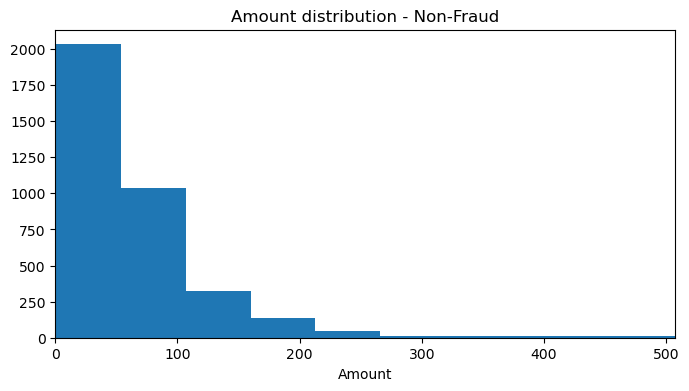

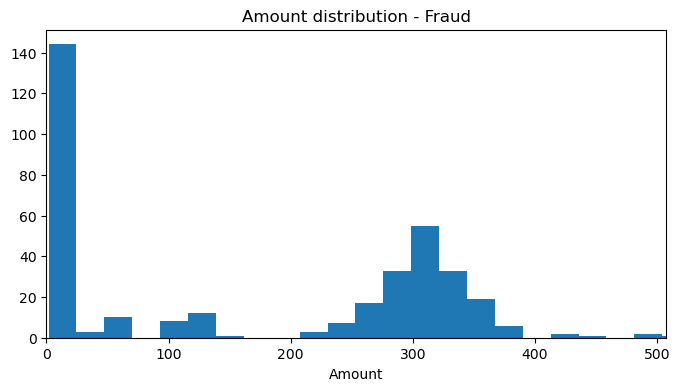

Counts by hour (first rows):


is_fraud_clean,0,1
hour_of_day,,
0.0,130,62
1.0,135,57
2.0,130,47
3.0,132,56
4.0,111,2
5.0,122,4
6.0,112,6
7.0,120,6
8.0,123,5


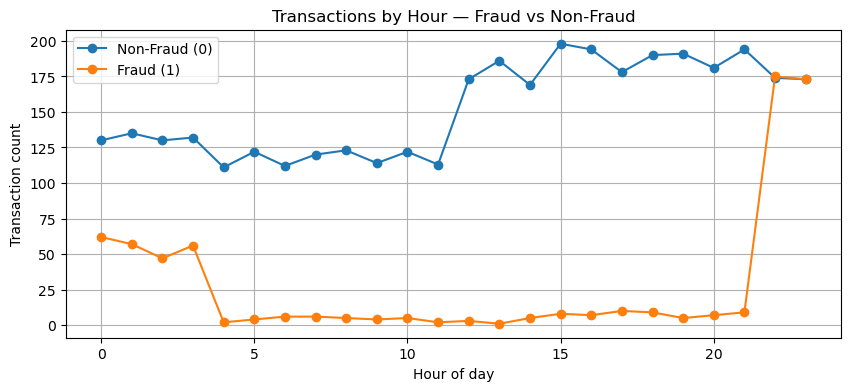

In [16]:

import matplotlib.pyplot as plt, numpy as np
if 'amt' in df_model.columns:
    stats = df_model.groupby('is_fraud_clean')['amt'].agg(['count','mean','median','std'])
    print("Amount stats by class:"); display(stats)
    nonfraud = df_model[df_model['is_fraud_clean']==0]['amt'].dropna()
    fraud = df_model[df_model['is_fraud_clean']==1]['amt'].dropna()
    # Non-fraud histogram
    plt.figure(figsize=(8,4))
    plt.hist(nonfraud, bins=60)
    plt.title("Amount distribution - Non-Fraud")
    plt.xlabel("Amount")
    plt.xlim(0, np.percentile(nonfraud,99))
    plt.show()
    # Fraud histogram
    plt.figure(figsize=(8,4))
    plt.hist(fraud, bins=60)
    plt.title("Amount distribution - Fraud")
    plt.xlabel("Amount")
    plt.xlim(0, np.percentile(nonfraud,99))
    plt.show()
else:
    print("No 'amt' column available.")

# Transactions by hour
if 'hour_of_day' in df_model.columns:
    counts = df_model.groupby(['hour_of_day','is_fraud_clean']).size().unstack(fill_value=0)
    print("Counts by hour (first rows):"); display(counts.head(24))
    hours = np.arange(0,24)
    nonf = counts.get(0, pd.Series(0,index=hours)).reindex(hours, fill_value=0)
    fr = counts.get(1, pd.Series(0,index=hours)).reindex(hours, fill_value=0)
    plt.figure(figsize=(10,4))
    plt.plot(hours, nonf, marker='o', label='Non-Fraud (0)')
    plt.plot(hours, fr, marker='o', label='Fraud (1)')
    plt.xlabel("Hour of day"); plt.ylabel("Transaction count")
    plt.title("Transactions by Hour — Fraud vs Non-Fraud")
    plt.legend(); plt.grid(True)
    plt.show()
else:
    print("No hour_of_day column available.")


## 9) Modeling — Logistic Regression & Random Forest

Train and evaluate Logistic Regression and Random Forest (class-weighted) and Random Forest on upsampled data (if created).

In [18]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
results = {}

def fit_eval(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    try:
        yprob = model.predict_proba(Xte)[:,1]
    except:
        try: yprob = model.decision_function(Xte)
        except: yprob = None
    print("=== Model:", name, "===")
    print(classification_report(yte, ypred, digits=4))
    cm = confusion_matrix(yte, ypred)
    print("Confusion matrix:", cm)
    aucv = roc_auc_score(yte, yprob) if yprob is not None else None
    print("ROC AUC:", aucv)
    results[name] = {'model': model, 'auc': aucv}
    return results[name]

# Logistic Regression with class weights
lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42)
fit_eval('LogReg_class_weight', lr, X_train_s, X_test_s, y_train, y_test)

# Random Forest with class weight on original train
rf = RandomForestClassifier(n_estimators=150, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
fit_eval('RF_class_weight', rf, X_train_s, X_test_s, y_train, y_test)

# Random Forest on upsampled balanced train (if present)
if X_train_bal_s is not None:
    rf2 = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
    fit_eval('RF_upsampled_train', rf2, X_train_bal_s, X_test_s, y_train_bal, y_test)
else:
    print("No balanced train present; skipped RF_upsampled_train")


=== Model: LogReg_class_weight ===
              precision    recall  f1-score   support

           0     0.9547    0.9495    0.9521       733
           1     0.7319    0.7537    0.7426       134

    accuracy                         0.9193       867
   macro avg     0.8433    0.8516    0.8474       867
weighted avg     0.9203    0.9193    0.9197       867

Confusion matrix: [[696  37]
 [ 33 101]]
ROC AUC: 0.8332552788580968
=== Model: RF_class_weight ===
              precision    recall  f1-score   support

           0     0.9613    0.9836    0.9724       733
           1     0.8974    0.7836    0.8367       134

    accuracy                         0.9527       867
   macro avg     0.9294    0.8836    0.9045       867
weighted avg     0.9515    0.9527    0.9514       867

Confusion matrix: [[721  12]
 [ 29 105]]
ROC AUC: 0.9601056789721244
=== Model: RF_upsampled_train ===
              precision    recall  f1-score   support

           0     0.9662    0.9741    0.9701       733

## 10) Compare performance (metrics table + ROC curves)

,roc_auc
model,
LogReg_class_weight,0.833255
RF_class_weight,0.960106
RF_upsampled_train,0.968449


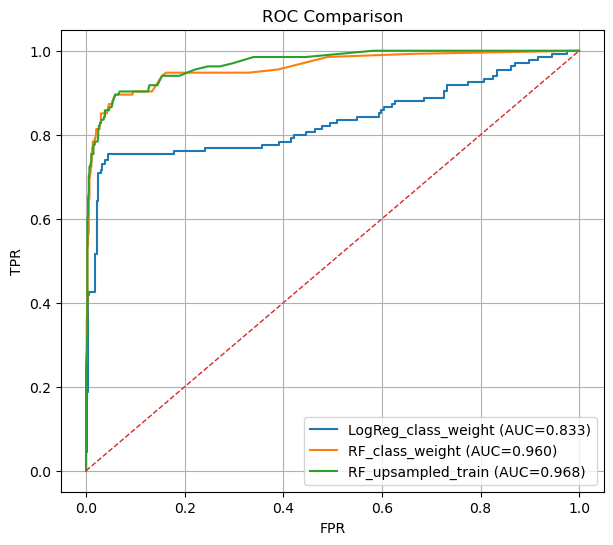

In [19]:

import pandas as pd
rows = []
for name, info in results.items():
    rows.append({'model':name, 'roc_auc':info['auc']})
metrics_df = pd.DataFrame(rows).set_index('model')
display(metrics_df)

# ROC curves for models that have probabilities
plt.figure(figsize=(7,6))
for name, info in results.items():
    model = info['model']
    try:
        yprob = model.predict_proba(X_test_s)[:,1]
    except:
        try: yprob = model.decision_function(X_test_s)
        except: yprob = None
    if yprob is not None:
        fpr, tpr, _ = roc_curve(y_test, yprob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={info['auc']:.3f})")
plt.plot([0,1],[0,1], '--', linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Comparison")
plt.legend(); plt.grid(True); plt.show()


## 11) Visualization & Dashboard
All important graphs are in this notebook (above). We also save key charts to `outputs/` for use in README or a Power BI import.

In [20]:

import os
outdir = "outputs"
os.makedirs(outdir, exist_ok=True)

# Save class distribution
plt.figure(figsize=(6,4))
counts = df_clean['is_fraud_clean'].value_counts().sort_index()
labels = ['non-fraud (0)','fraud (1)']
values = [counts.get(0,0), counts.get(1,0)]
plt.bar(labels, values); plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.tight_layout(); plt.savefig(os.path.join(outdir, "class_distribution.png")); plt.close()

# Save example amount histograms if available
if 'amt' in df_model.columns:
    nonfraud = df_model[df_model['is_fraud_clean']==0]['amt'].dropna()
    fraud = df_model[df_model['is_fraud_clean']==1]['amt'].dropna()
    plt.figure(figsize=(8,4)); plt.hist(nonfraud, bins=60); plt.xlim(0, np.percentile(nonfraud,99))
    plt.tight_layout(); plt.savefig(os.path.join(outdir, "amount_nonfraud.png")); plt.close()
    plt.figure(figsize=(8,4)); plt.hist(fraud, bins=60); plt.xlim(0, np.percentile(nonfraud,99))
    plt.tight_layout(); plt.savefig(os.path.join(outdir, "amount_fraud.png")); plt.close()

# Save ROC plot
plt.figure(figsize=(7,6))
for name, info in results.items():
    model = info['model']
    try: yprob = model.predict_proba(X_test_s)[:,1]
    except:
        try: yprob = model.decision_function(X_test_s)
        except: yprob = None
    if yprob is not None:
        fpr,tpr,_ = roc_curve(y_test, yprob)
        plt.plot(fpr,tpr, label=f"{name} (AUC={info['auc']:.3f})")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(outdir, "roc_comparison.png")); plt.close()

print("Saved outputs to", outdir)


Saved outputs to outputs
